# Classical Autoencoder

In this notebook we train a very simple classical Convolutional Autoencoder on a reduced version of the Quark Gluon dataset.

## imports

In [ ]:
# Needed for AdamW optimizer
!pip install -q tensorflow-addons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow_addons as tfa

2024-06-21 11:48:53.520592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 11:48:53.909768: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-21 11:48:53.909814: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-21 11:48:57.009510: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

## Data

load the dataset

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [2]:
f = h5py.File("/content/drive/MyDrive/QG_hackathon_data_big", "r")

In [3]:
x_train = f.get("X")
y_train = f.get("y")

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train[:], y_train[:], test_size=0.2, shuffle=True
)

like in the other notebooks we normalize the images by dividing every image by its largest pixel value. In addition we split the quarks (1) and gluons (0).

In [5]:
x_train_ones = x_train[y_train == 1]
x_train_ones = x_train_ones.reshape(x_train_ones.shape + (1,))
x_train = x_train[y_train == 0]
x_train = x_train.reshape(x_train.shape + (1,))

div1 = np.max(x_train, axis=(1, 2)).reshape((x_train.shape[0], 1, 1, 1))
div1[div1 == 0] = 1
x_train = x_train / div1
div2 = np.max(x_train_ones, axis=(1, 2)).reshape((x_train_ones.shape[0], 1, 1, 1))
div2[div2 == 0] = 1
x_train_ones = x_train_ones / div2

x_val_ones = x_val[y_val == 1]
x_val_ones = x_val_ones.reshape(x_val_ones.shape + (1,))
x_val = x_val[y_val == 0]
x_val = x_val.reshape(x_val.shape + (1,))

div1 = np.max(x_val, axis=(1, 2)).reshape((x_val.shape[0], 1, 1, 1))
div1[div1 == 0] = 1
x_val = x_val / div1
div2 = np.max(x_val_ones, axis=(1, 2)).reshape((x_val_ones.shape[0], 1, 1, 1))
div2[div2 == 0] = 1
x_val_ones = x_val_ones / div2

## Model

We build the Autoencoder model

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from keras.initializers import Constant
from keras.layers import PReLU


class Convolutional_Autoencoder(Model):
    """Convolutional Autoencoder model specifically for comparasion with Quantum models with a small number of parameters"""

    def __init__(self, latent_dim):
        """Create the model with given latenspace. Will have around 3000 parameters

        Args:
          latent_dim (int): number of latent neurons"""
        super(Convolutional_Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential(
            [
                layers.Input(shape=(30, 30, 1)),
                layers.Conv2D(10, kernel_size=4, strides=1, padding="same"),
                PReLU(alpha_initializer=Constant(value=0.25)),
                layers.AveragePooling2D(pool_size=2),
                layers.Conv2D(5, kernel_size=4, strides=1, padding="same"),
                PReLU(alpha_initializer=Constant(value=0.25)),
                layers.AveragePooling2D(pool_size=2),
                layers.Conv2D(5, kernel_size=2, strides=1, padding="same"),
                PReLU(alpha_initializer=Constant(value=0.25)),
                layers.Flatten(),
                layers.Dense(25),
                PReLU(alpha_initializer=Constant(value=0.25)),
                layers.Dense(latent_dim),
                PReLU(alpha_initializer=Constant(value=0.25)),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(81 * 1),
                PReLU(alpha_initializer=Constant(value=0.25)),
                layers.Reshape((9, 9, 1)),
                layers.Conv2D(5, kernel_size=2, strides=1, padding="same"),
                PReLU(alpha_initializer=Constant(value=0.25)),
                layers.UpSampling2D(size=2),
                layers.Conv2D(5, kernel_size=4, strides=1, padding="same"),
                PReLU(alpha_initializer=Constant(value=0.25)),
                layers.UpSampling2D(size=2),
                layers.Conv2D(10, kernel_size=4, strides=1, padding="valid"),
                PReLU(alpha_initializer=Constant(value=0.25)),
                layers.Conv2D(
                    1, kernel_size=4, strides=1, activation="sigmoid", padding="valid"
                ),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = Convolutional_Autoencoder(27)

2024-06-21 11:49:05.330178: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-21 11:49:05.332137: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-21 11:49:05.332175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2024-06-21 11:49:05.332606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.build(input_shape=(1, 30, 30, 1))

This is what the model looks like:

In [9]:
model.summary()

Model: "convolutional__autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 27)                18354     
                                                                 
 sequential_1 (Sequential)   (1, 30, 30, 1)            16665     
                                                                 
Total params: 35,019
Trainable params: 35,019
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 10)        170       
                                                                 
 p_re_lu (PReLU)             (None, 30, 30, 10)        9000      
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 10)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 5)         805       
                                                                 
 p_re_lu_1 (PReLU)           (None, 15, 15, 5)         1125      
                                                                 
 average_pooling2d_1 (Averag  (None, 7, 7, 5)          0         
 ePooling2D)                                            

In [11]:
model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (1, 81)                   2268      
                                                                 
 p_re_lu_5 (PReLU)           (1, 81)                   81        
                                                                 
 reshape (Reshape)           (1, 9, 9, 1)              0         
                                                                 
 conv2d_3 (Conv2D)           (1, 9, 9, 5)              25        
                                                                 
 p_re_lu_6 (PReLU)           (1, 9, 9, 5)              405       
                                                                 
 up_sampling2d (UpSampling2D  (1, 18, 18, 5)           0         
 )                                                               
                                                      

## Training

I use adamw as optimizer

In [12]:
learning_rate = 0.0001
weight_decay = 0.00005
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [13]:
model.compile(loss="binary_crossentropy", optimizer=optimizer)

We use early stopping on the validation loss. Training can take some time as we have to train for a lot of epochs.

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, min_delta=5e-6)
hist = model.fit(
    x_train_ones,
    x_train_ones,
    epochs=100,
    validation_data=(x_val_ones, x_val_ones),
    callbacks=[es],
    batch_size=128,
)

Epoch 1/100
392/392 [==============================] - 98s 243ms/step - loss: 0.2382 - val_loss: 0.0195
Epoch 2/100
392/392 [==============================] - 93s 238ms/step - loss: 0.0182 - val_loss: 0.0178
Epoch 3/100
392/392 [==============================] - 104s 265ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 4/100
392/392 [==============================] - 103s 262ms/step - loss: 0.0172 - val_loss: 0.0173
Epoch 5/100
392/392 [==============================] - 101s 256ms/step - loss: 0.0170 - val_loss: 0.0170
Epoch 6/100
392/392 [==============================] - 94s 240ms/step - loss: 0.0168 - val_loss: 0.0168
Epoch 7/100
392/392 [==============================] - 90s 231ms/step - loss: 0.0165 - val_loss: 0.0166
Epoch 8/100
392/392 [==============================] - 90s 230ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 9/100
392/392 [==============================] - 91s 232ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 10/100
392/392 [==============================] - 95s 2

# Evaluation

We can check the loss and auc history

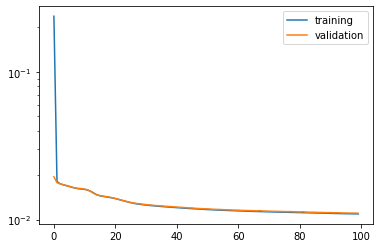

In [15]:
plt.plot(hist.history["loss"], label="training")
plt.plot(hist.history["val_loss"], label="validation")
plt.yscale("log")
plt.legend()

and evaluate the reconstruction abilities.
First on the data it was trained on

In [16]:
def eval_recon(x_test, x_recon, lognorm=False):
    """Evaluate the reconstruction capabilities of an autoencoder

    Args:
        x_true (array): True images
        x_recon (array): reconstructed image
        lognorm (bool): use logarithmic norm for example images

    Returns:
        evaluation plots
    """
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
    x_recon = x_recon.reshape(x_recon.shape[0], x_recon.shape[1], x_recon.shape[2], 1)

    ssim = tf.reduce_mean(
        tf.image.ssim(x_test.astype("float64"), x_recon.astype("float64"), max_val=1.0)
    ).numpy()
    MAE = tf.reduce_mean(tf.abs(x_test - x_recon)).numpy()
    normalized_MAE = (
        MAE
        / tf.reduce_mean(
            tf.reduce_sum(x_test, axis=(1, 2))
            .numpy()
            .reshape((x_test.shape[0], 1, 1, 1))
        ).numpy()
    )

    print(f"ssim: {ssim:.3}")
    print(f"MAE: {MAE:.3}")
    print(f"normalized MAE: {normalized_MAE:.3}")

    fig, axs = plt.subplots(2, 3, figsize=(10, 5))

    if lognorm:
        norm = LogNorm()
    else:
        norm = None

    for i in range(3):
        rint = np.random.randint(len(x_test))
        axs[0, i].imshow(x_test[rint], cmap="binary", norm=norm)
        axs[0, i].title.set_text("true")

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap="binary"), ax=axs[0, i])

        axs[1, i].imshow(x_recon[rint], cmap="binary", norm=norm)
        axs[1, i].title.set_text("reconstructed")

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap="binary"), ax=axs[1, i])

    fig.tight_layout()

389/389 [==============================] - 11s 27ms/step
ssim: 0.882
MAE: 0.00359
normalized MAE: 0.00119


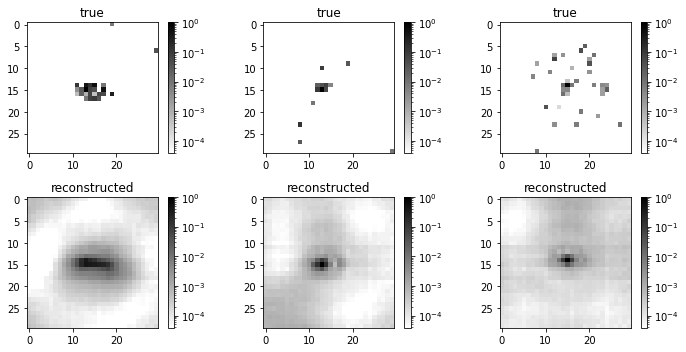

In [17]:
recon = model.predict(x_val_ones)

eval_recon(x_val_ones, recon, lognorm=True)

And now on the anomalous signal samples.

393/393 [==============================] - 12s 31ms/step
ssim: 0.813
MAE: 0.00539
normalized MAE: 0.00138


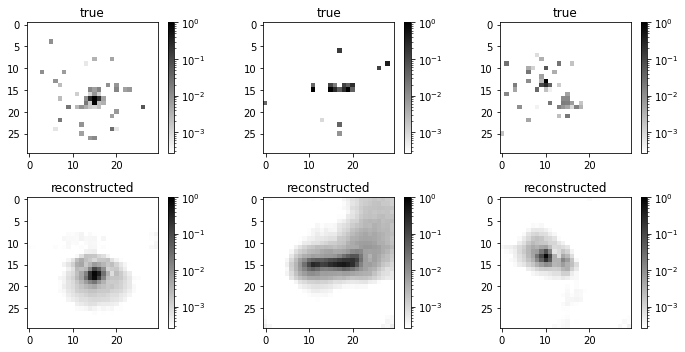

In [18]:
recon = model.predict(x_val)

eval_recon(x_val, recon, lognorm=True)

This is again the anomaly tagging performance

In [19]:
def eval_tagging(x_true_background, x_recon_background, x_true_signal, x_recon_signal):
    """Evaluate the anomaly tagging capabilities of an autoencoder

    Args:
        x_true_background (array): True images of background events
        x_recon_background (array): reconstructed images of background events
        x_true_signal (array): True images of signal events
        x_recon_signal (array): reconstructed images of signal events

    Returns:
        Plots for tagging evaluation
    """
    x_true_background = x_true_background.reshape(
        x_true_background.shape[0],
        x_true_background.shape[1],
        x_true_background.shape[2],
        1,
    )
    x_recon_background = x_recon_background.reshape(
        x_recon_background.shape[0],
        x_recon_background.shape[1],
        x_recon_background.shape[2],
        1,
    )
    x_true_signal = x_true_signal.reshape(
        x_true_signal.shape[0], x_true_signal.shape[1], x_true_signal.shape[2], 1
    )
    x_recon_signal = x_recon_signal.reshape(
        x_recon_signal.shape[0], x_recon_signal.shape[1], x_recon_signal.shape[2], 1
    )

    bce_background = tf.keras.losses.binary_crossentropy(
        x_true_background, x_recon_background, axis=(1, 2, 3)
    ).numpy()
    bce_signal = tf.keras.losses.binary_crossentropy(
        x_true_signal, x_recon_signal, axis=(1, 2, 3)
    ).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(11, 4))

    print(f"Median background: {np.median(bce_background):.3}")
    print(f"Median signal: {np.median(bce_signal):.3}")
    bins = np.histogram(np.hstack((bce_background, bce_signal)), bins=25)[1]
    axs[0].hist(bce_background, histtype="step", label="background", bins=bins)
    axs[0].hist(bce_signal, histtype="step", label="signal", bins=bins)
    axs[0].set_xlabel("loss")
    axs[0].legend()

    thresholds = np.linspace(0, max(np.max(bce_background), np.max(bce_signal)), 1000)

    accs = []
    for i in thresholds:
        num_background_right = np.sum(bce_background < i)
        num_signal_right = np.sum(bce_signal > i)
        acc = (num_background_right + num_signal_right) / (
            len(x_recon_background) + len(x_recon_signal)
        )
        accs.append(acc)

    print(f"Maximum accuracy: {np.max(accs):.3}")
    axs[1].plot(thresholds, accs)
    axs[1].set_xlabel("anomaly threshold")
    axs[1].set_ylabel("tagging accuracy")

    y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
    y_pred = np.append(bce_background, bce_signal)
    auc = roc_auc_score(y_true, y_pred)
    print(f"AUC: {auc:.4}")
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    tnr = 1 - fpr
    x = np.linspace(0, 1, 50)
    y_rnd = 1 - x
    axs[2].plot(tnr, tpr, label="anomaly tagging")
    axs[2].plot(x, y_rnd, label="random tagging", color="grey")
    axs[2].set_xlabel("fpr")
    axs[2].set_ylabel("tpr")
    axs[2].legend()

    fig.tight_layout()

389/389 [==============================] - 12s 32ms/step
Median background: 0.00874
Median signal: 0.0139
Maximum accuracy: 0.617
AUC: 0.6605


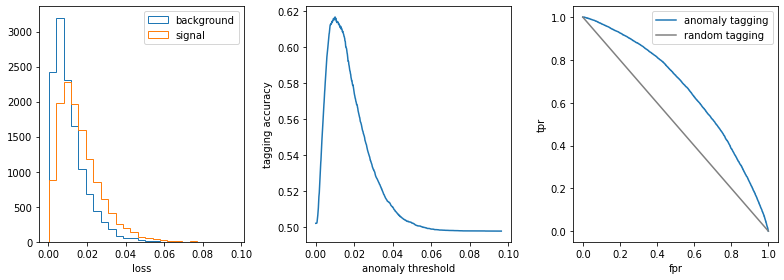

In [20]:
recon = model.predict(x_val)
recon_1 = model.predict(x_val_ones)

eval_tagging(x_val_ones, recon_1, x_val, recon)